In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "python")

from estimagic.optimization.optimize import maximize
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numdifftools as nd
import pandas as pd
import respy as rp
import numpy as np

from calibration_maximum_likelihood import get_bootstrap_sample
from calibration_maximum_likelihood import run_bootstrap
from auxiliary import plot_bootstrap_distribution
from auxiliary import plot_smoothing_parameter
from auxiliary import plot_profile_likelihood
from auxiliary import plot_score_distribution
from auxiliary import plot_score_function

warnings.simplefilter(action="ignore", category=RuntimeWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Maximum likelihood estimation


* Likelihood function

* Score function and statistic

    * Asymptotic distribution
    * Linearity
    
    
* Confidence intervals

    * Wald
    * Likelihood - based
    * Bootstrap
    
    
* Numerical approximations

    * Function smoothing


Most of the material is from the following two references:

* https://www.amazon.de/dp/0199671222/ref=sr_1_1?keywords=in+all+likelihood&qid=1573806115&sr=8-1

* https://www.amazon.de/dp/0534243126/ref=sr_1_1?keywords=casella+berger&qid=1573806129&sr=8-1

Let's get started!

In [2]:
params_base, options_base, df = rp.get_example_model("robinson", with_data=True)

Let us briefly inspect the parameterization.

In [3]:
params_base

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

Several options need to be specified as well.

In [4]:
options_base

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

We can now look at the simulated dataset.

In [5]:
df.head()

,Identifier,Period,Choice,Wage,Experience_Fishing,Type,Nonpecuniary_Reward_Fishing,Nonpecuniary_Reward_Hammock,Wage_Fishing,Flow_Utility_Fishing,Flow_Utility_Hammock,Value_Function_Fishing,Value_Function_Hammock,Shock_Reward_Fishing,Shock_Reward_Hammock,Discount_Rate
0,0,0,fishing,1.007197,0,0,-0.1,1.046,1.000000,0.907197,1.056305,4.747093,4.744600,1.007197,0.010305,0.95
1,0,1,fishing,1.082581,1,0,-0.1,1.046,1.072508,0.982581,1.046042,4.050283,3.892430,1.009392,0.000042,0.95
2,0,2,fishing,1.163836,2,0,-0.1,1.046,1.150274,1.063836,1.053231,3.244500,3.073945,1.011790,0.007231,0.95
3,0,3,fishing,1.239123,3,0,-0.1,1.046,1.233678,1.139123,1.048698,2.301106,2.125701,1.004414,0.002698,0.95
4,0,4,fishing,1.292003,4,0,-0.1,1.046,1.323130,1.192003,1.030870,1.192003,1.030870,0.976475,-0.015130,0.95


## Likelihood function

We can now start exploring the likelihood function. The likelihood function is a measure of information about the potentially unknown parameters of the model. The information will usually be incomplete and the likelihood function also expresses the degree of incompleteness.

### Profile likelihood

We will first trace out the profile likelihood over reasonable parameter values. 

In [6]:
params_base["lower"] = [0.91, 0.065, -0.20, 1.00, 0.0030, 0.001, -0.99]
params_base["upper"] = [0.99, 0.075,  0.00, 1.10, 0.1000, 0.030, +0.99]

We plot the normalized likelihood, i.e. set the maximum of the likelihood function to one by dividing it by its maximum. 

In [7]:
crit_func = rp.get_crit_func(params_base, options_base, df)

rslts = dict()
for index in params_base.index:

    upper, lower = params_base.loc[index][["upper", "lower"]]
    grid = np.linspace(lower, upper, 20)

    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(np.exp(crit_func(params)))

    rslts[index] = fvals

Let's visualize the results.

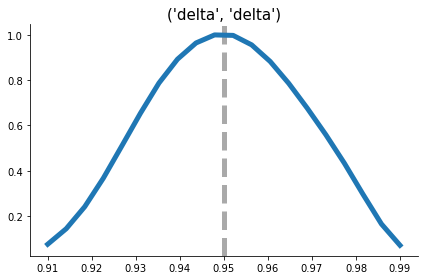

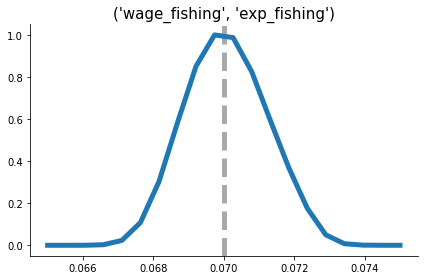

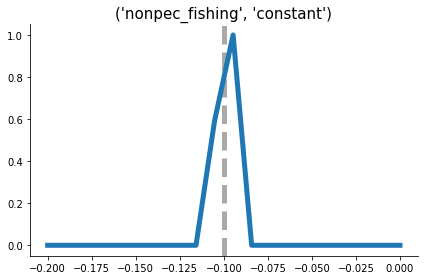

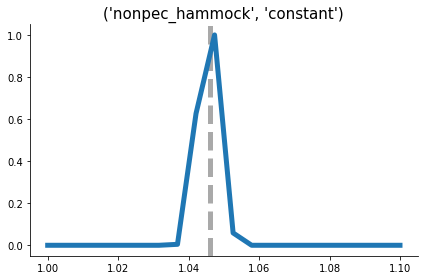

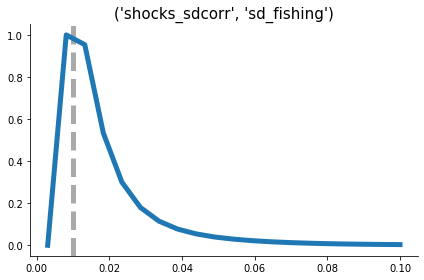

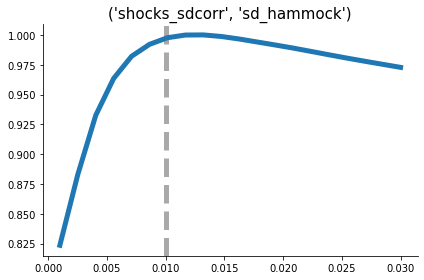

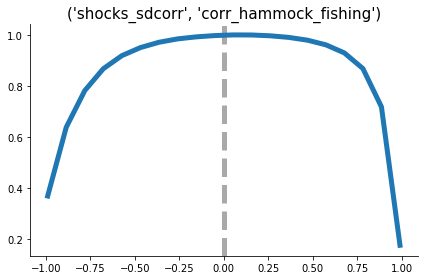

In [8]:
plot_profile_likelihood(rslts, params_base)

## Maximum likelihood estimate

So far, we looked at the likelihood function in its entirety. Going forward, we will take a narrower view and just focus on the maximum likelihood estimate. We restrict our attention to the discount factor $\delta$ and treat it as the only unknown parameter. We will use [estimagic](https://estimagic.readthedocs.io/) for all our estimations. 

In [9]:
crit_func = rp.get_crit_func(params_base, options_base, df)

# We will use estimagic and fix all parameters at their true values.
constr_base = [
    {"loc": ("shocks_sdcorr", "sd_fishing"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "sd_hammock"), "type": "fixed"}, 
    {"loc": ("shocks_sdcorr", "corr_hammock_fishing"), "type": "fixed"}, 
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type": "fixed"}
]

# We want a more interesting starting value.
params_start = params_base.copy()
params_start.loc[("delta", "delta"), "value"] = 0.91

algo_options = {"maxeval": 100}
algo_name = "nlopt_bobyqa"

results, params_rslt = maximize(crit_func, params_base, algo_name, algo_options=algo_options, constraints=constr_base)

Let's look at the results.

In [10]:
params_rslt

value  lower  upper           group  \
category       name                                                           
delta          delta                 0.949786  0.910  0.990  All Parameters   
wage_fishing   exp_fishing           0.070000  0.065  0.075  All Parameters   
nonpec_fishing constant             -0.100000 -0.200  0.000  All Parameters   
nonpec_hammock constant              1.046000  1.000  1.100  All Parameters   
shocks_sdcorr  sd_fishing            0.010000  0.003  0.100  All Parameters   
               sd_hammock            0.010000  0.001  0.030  All Parameters   
               corr_hammock_fishing  0.000000 -0.990  0.990  All Parameters   

                                                                   name  \
category       name                                                       
delta          delta                                        delta_delta   
wage_fishing   exp_fishing                     wage_fishing_exp_fishing   
nonpec_fishing constant                         nonpec_fishing_constant   
nonpec_hammock constant                         nonpec_hammock_constant   
shocks_sdcorr  sd_fishing                      shocks_sdcorr_sd_fishing   
               sd_hammock                      shocks_sdcorr_sd_hammock   
               corr_hammock_fishing  shocks_sdcorr_corr_hammock_fishing   

                                     _fixed_value  _is_fixed_to_value  \
category       name                                                     
delta          delta                          NaN               False   
wage_fishing   exp_fishing                  0.070                True   
nonpec_fishing constant                    -0.100                True   
nonpec_hammock constant                     1.046                True   
shocks_sdcorr  sd_fishing                   0.010                True   
               sd_hammock                   0.010                True   
               corr_hammock_fishing         0.000                True   

                                     _post_replacements  _is_fixed_to_other  \
category       name                                                           
delta          delta                                 -1               False   
wage_fishing   exp_fishing                           -1               False   
nonpec_fishing constant                              -1               False   
nonpec_hammock constant                              -1               False   
shocks_sdcorr  sd_fishing                            -1               False   
               sd_hammock                            -1               False   
               corr_hammock_fishing                  -1               False   

                                     _internal_lower  _internal_upper  \
category       name                                                     
delta          delta                           0.910            0.990   
wage_fishing   exp_fishing                     0.065            0.075   
nonpec_fishing constant                       -0.200            0.000   
nonpec_hammock constant                        1.000            1.100   
shocks_sdcorr  sd_fishing                      0.003            0.100   
               sd_hammock                      0.001            0.030   
               corr_hammock_fishing           -0.990            0.990   

                                     _internal_free  _pre_replacements  \
category       name                                                      
delta          delta                           True                  0   
wage_fishing   exp_fishing                    False                 -1   
nonpec_fishing constant                       False                 -1   
nonpec_hammock constant                       False                 -1   
shocks_sdcorr  sd_fishing                     False                 -1   
               sd_hammock                     False                 -1   
               corr_hammock_fish

In [11]:
results

{'fun': 9.033492283971766}

We need to set up a proper interface to use some other Python functionality going forward.

In [12]:
def wrapper_crit_func(crit_func, params_base, value):

    params = params_base.copy()
    params.loc["delta", "value"] = value

    return crit_func(params)

p_wrapper_crit_func = partial(wrapper_crit_func, crit_func, params_base)

We need to use the MLE repeatedly going forward.

In [13]:
delta_hat = params_rslt.loc[("delta", "delta"), "value"]

At the maximum, the second derivative of the log-likelihood is negative and we define the observed Fisher information  as follows

\begin{align*}
I{\theta} \equiv -\frac{\partial^2 \log L(\theta)}{\partial^2 \theta}
\end{align*}

In [14]:
delta_fisher = -nd.Derivative(p_wrapper_crit_func, n=2)([delta_hat]) 

## Score statistic and Score function

The Score function is the first-derivative of the log-likelihood.

\begin{align*}
S(\theta) \equiv \frac{\partial \log L(\theta)}{\partial \theta}
\end{align*}


### Distribution

The asymptotic normality of the score statistic is of key importance in deriving the asymptotic normality of the maximum likelihood estimator. Here we simulate $1,000$ samples of $10,000$ individuals and compute the score function at the true values. I had to increase the number of simulated individuals as convergence to the asymptotic distribution just took way to long.

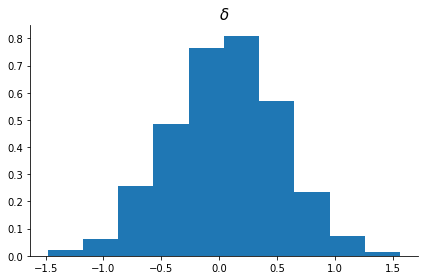

In [15]:
plot_score_distribution()

### Linearity

We need linearity of the score function around the true value so that the log-likelihood is reasonably well approximated by a second order Taylor-polynomial. 

\begin{align*}
\log L(\theta) \approx \log L(\hat{\theta}) + S(\hat{\theta})(\theta - \hat{\theta}) - \tfrac{1}{2} I(\hat{\theta}))(\theta - \hat{\theta})^2
\end{align*}


Under the usual conditions, the following relationship is approximately true:

\begin{align*}
- I^{-1/2}(\hat{\theta}) S(\theta) \approx I^{-1/2} (\theta - \hat{\theta})
\end{align*}



In [16]:
num_points, index = 10, ("delta", "delta")

upper, lower = params_base.loc[index, ["upper", "lower"]]
grid = np.linspace(lower, upper, num_points)

fds = np.tile(np.nan, num_points)
for i, point in enumerate(grid):
    fds[i] = nd.Derivative(p_wrapper_crit_func, n=1)([point]) 

norm_fds = fds * - (1 / np.sqrt(delta_fisher))
norm_grid = (grid - 0.95) *   (np.sqrt(delta_fisher))

In the best case we see a standard normal distribution of $I^{1/2} (\hat{\theta}) (\theta - \hat{\theta})$ and so it is common practive to evaluate the linearity over $-2$ and $2$.

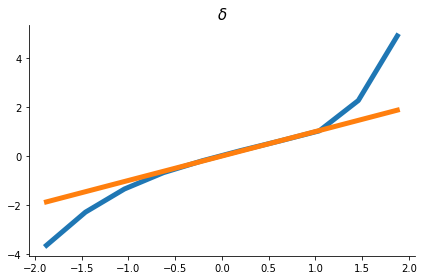

In [17]:
plot_score_function(norm_grid, norm_fds)

## Confidende intervals

### Wald intervals

In [18]:
rslt = list()
rslt.append(0.95 - 1.96 * 1 / np.sqrt(delta_fisher))
rslt.append(0.95 + 1.96 * 1 / np.sqrt(delta_fisher))
"{:5.3f} / {:5.3f}".format(*rslt)

'0.908 / 0.992'

### Likelihood-based intervals

The likelihood-based intervals do only rely on the asymptoric normality of the score function and not its linearity.

In [19]:
def root_wrapper(delta, alpha, index):
    
    crit_val = np.exp(-0.5 * chi2.ppf(1 - alpha, 1))
    
    params_eval = params_base.copy()
    params_eval.loc[("delta", "delta"), "value"] = delta
    likl_ratio = np.exp(crit_func(params_eval)- crit_func(params_base))    
                      
    return likl_ratio - crit_val

In [20]:
brackets = [[0.75, 0.95], [0.95, 1.10]]

rslt = list()
for bracket in brackets:
    root = root_scalar(root_wrapper, method="bisect", bracket=bracket, args=(0.05, index)).root
    rslt.append(root)
print("{:5.3f} / {:5.3f}".format(*rslt))

0.914 / 0.986


### Bootstrap

We can now run a simple bootstrap to see how the asymptotic standard errors line up.

Here are some useful resources on the topic:

* https://www.scholars.northwestern.edu/en/publications/chapter-52-the-bootstrap



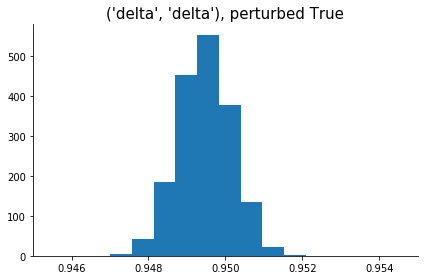

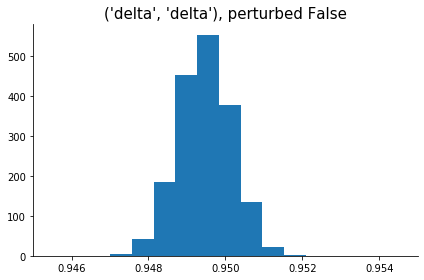

In [21]:
plot_bootstrap_distribution()

## Numerical aspects

THe shape and properties of the likelihood function are determined by different numerical tuning parameters.

### Smoothing parameter

There are many numerical tuning parameters involved in the construction of the likelihood function (e.g. numerical integration, smoothing parameter). We now show the shape of the likelihood function for alternative choices of the smoothing parameter $\tau$.

* https://www.jstor.org/stable/1913621?seq=1#metadata_info_tab_contents

* https://www.amazon.de/dp/B00D2WQ02U/ref=sr_1_1?keywords=bootstrap+methods+and+their+application&qid=1574070350&s=digital-text&sr=1-1

In [22]:
rslts = dict()

for tau in [0.01, 0.001, 0.0001]:

    index = ("delta", "delta")
    
    options = options_base.copy()
    options["estimation_tau"] = tau

    crit_func = rp.get_crit_func(params_base, options, df)
    grid = np.linspace(0.948, 0.952, 20)
    
    fvals = list()
    for value in grid:
        params = params_base.copy()
        params.loc[index, "value"] = value
        fvals.append(crit_func(params))

    rslts[tau] = fvals - np.max(fvals)

Now we are ready to inspect the shape of the likelihood function.

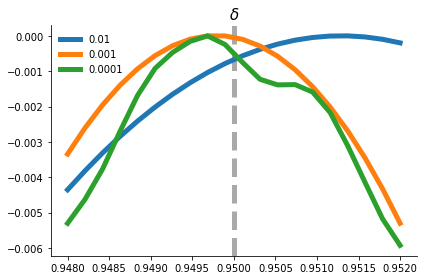

In [23]:
plot_smoothing_parameter(rslts, params_base, grid)